This notebook has :

* GrabCut
*Watershed Implementation
*  Thresholding
*  K-means

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import numpy as np
import cv2
import shutil
from collections import defaultdict
import requests
import tarfile
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from skimage import measure, color
from skimage.segmentation import clear_border
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import os
from glob import glob
from keras import models
from keras.models import load_model
from IPython.display import Image, display


%matplotlib inline

In [ ]:
# Define paths and parameters
scorecam_dir = '/content/test_resnet_cam'
target_size = (180,180)

##Watershed Algorithm
It is a powerful image segmentation technique that uses topographic information to divide an image into multiple segments or regions. The watershed algorithm is more thoughtful than other segmentation methods, and it is more in line with the impression of the human eye on the image.

[Source](https://www.geeksforgeeks.org/image-segmentation-with-watershed-algorithm-opencv-python/)


In [ ]:
def create_watershed_mask(scorecam_path, target_size):
    img = cv2.imread(scorecam_path)
    if img is None:
        raise ValueError(f"Unable to read the image at {scorecam_path}")

    #cells = img[:, :, 0]  # Use the blue channel
    #cells  = img[:, :, 1] #green
    #cells = img[:, :, 2] #red
    cells = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_resized = cv2.resize(img, target_size)
    cells_resized = img_resized[:, :, 0]

    ret1, thresh = cv2.threshold(cells_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to remove small noise - opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    opening = clear_border(opening)  # Remove edge touching grains

    # Identifying sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=5)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
    ret2, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Create a marker and label the regions inside
    ret3, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 10
    markers[unknown == 255] = 0

    # Watershed algorithm
    markers = cv2.watershed(img_resized, markers)

    # Create mask
    mask = np.zeros_like(markers, dtype=np.uint8)
    mask[markers > 1] = 1  # Use the regions marked by watershed

    return mask, markers

In [ ]:
scorecam_path = '/content/test_resnet_cam/40/00040_00000_00017.png'

In [ ]:
mask, markers = create_watershed_mask(scorecam_path, target_size)

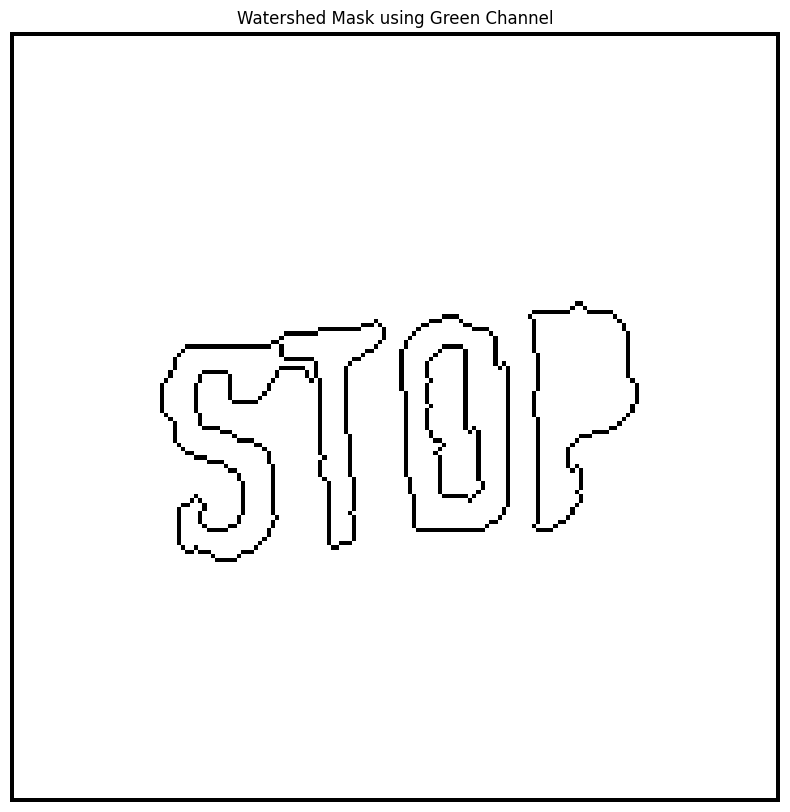

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title('Watershed Mask using Green Channel')
plt.axis('off')
plt.show()

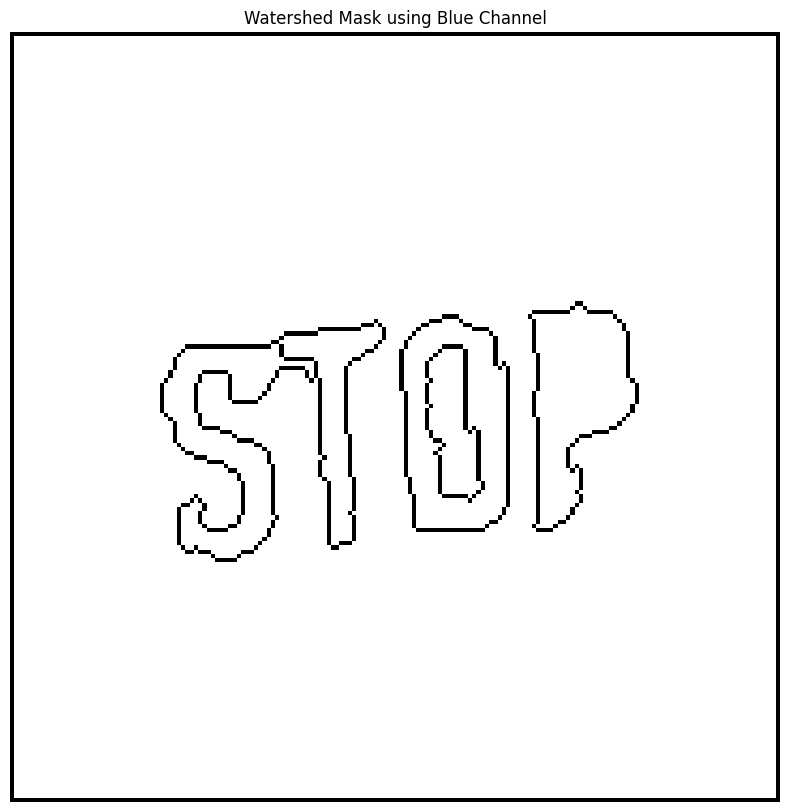

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title('Watershed Mask using Blue Channel')
plt.axis('off')
plt.show()

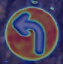

In [ ]:

# Plot the image
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".jpg", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

#Image loading
img = cv2.imread("/content/gradcam_00034_00004_00014.png")
# Show image
imshow(img)

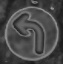

In [ ]:
#image grayscale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

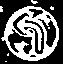

In [ ]:
#Threshold Processing
ret, bin_img = cv2.threshold(gray,
							0, 255,
							cv2.THRESH_OTSU)
imshow(bin_img)

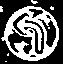

In [ ]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
bin_img = cv2.morphologyEx(bin_img,
						cv2.MORPH_OPEN,
						kernel,
						iterations=5)
imshow(bin_img)

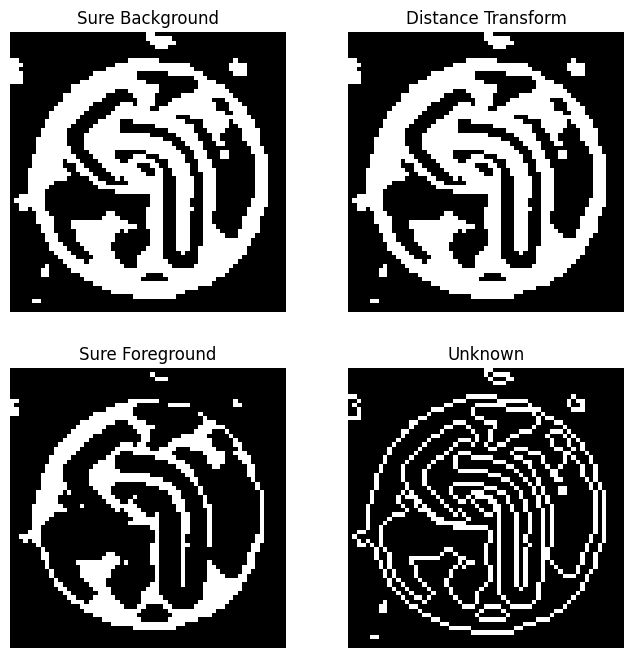

In [ ]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=5)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')

#foreground area
ret, sure_fg = cv2.threshold(dist, 0.3 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')

plt.show()

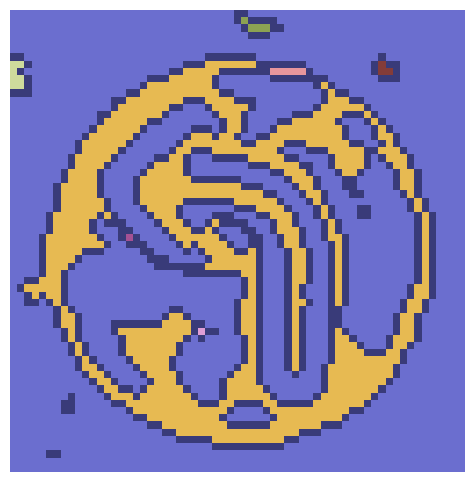

In [ ]:
# Marker labelling
# sure foreground
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


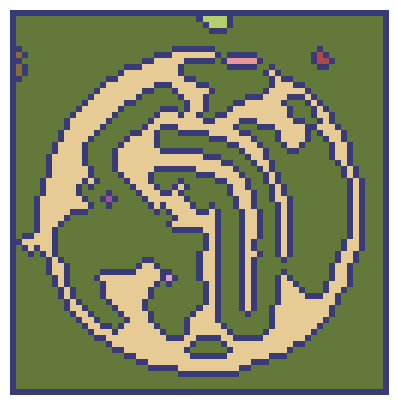

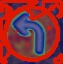

In [ ]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]:

# Create a binary image in which only the area of the label is in the foreground
#and the rest of the image is in the background
	target = np.where(markers == label, 255, 0).astype(np.uint8)

# Perform contour extraction on the created binary image
	contours, hierarchy = cv2.findContours(
		target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
	)
	coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)


##GRADCAM

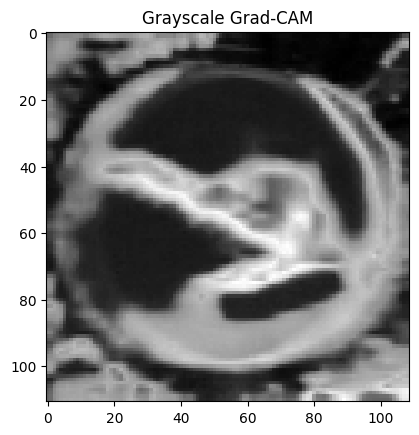

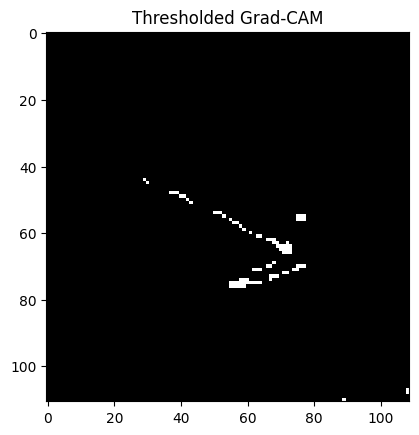

'/content/grad3.png'

In [ ]:
# Load the Grad-CAM image
grad_cam_img = cv2.imread('/content/gradcam_00038_00041_00029.png')

# Convert to grayscale
gray_grad_cam = cv2.cvtColor(grad_cam_img, cv2.COLOR_BGR2GRAY)

# Visualize the grayscale image
plt.imshow(gray_grad_cam, cmap='gray')
plt.title('Grayscale Grad-CAM')
plt.show()

# Apply a different thresholding technique to get the important regions
_, thresh_img = cv2.threshold(gray_grad_cam, 150, 255, cv2.THRESH_BINARY)

# Visualize the thresholded image
plt.imshow(thresh_img, cmap='gray')
plt.title('Thresholded Grad-CAM')
plt.show()

# Find contours in the thresholded image
contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes on the original image
img_with_boxes = grad_cam_img.copy()
for cnt in contours:
    if cv2.contourArea(cnt) > 500:  # Increase the area filter threshold
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Save the result
output_path_corrected = '/content/grad3.png'
cv2.imwrite(output_path_corrected, img_with_boxes)

output_path_corrected


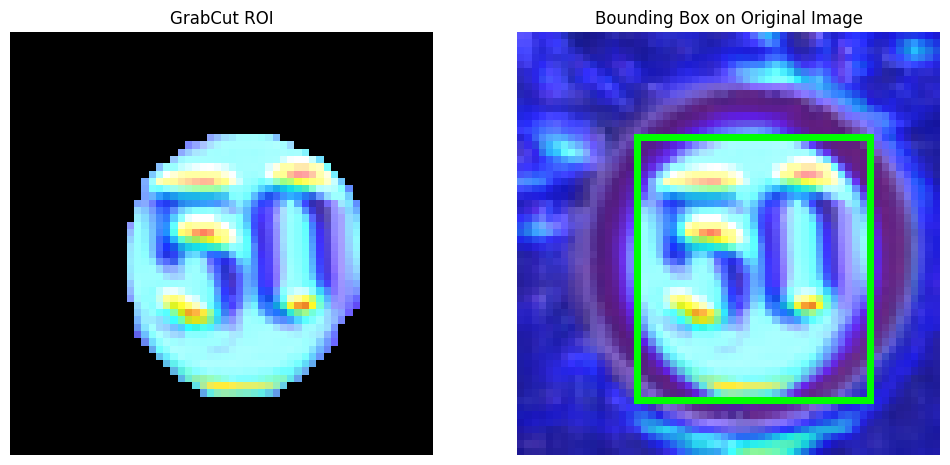

In [ ]:

def extract_roi_grabcut(scorecam_path, threshold=0.5):
    scorecam_img = cv2.imread(scorecam_path, cv2.IMREAD_GRAYSCALE)
    if scorecam_img is None:
        raise ValueError(f"Unable to read the image at {scorecam_path}")

    # Normalize the image
    scorecam_img = scorecam_img / 255.0

    # Apply adaptive thresholding to get the important regions
    thresholded_img = cv2.adaptiveThreshold(
        (scorecam_img * 255).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2)

    # Read the original image
    original_img_path = scorecam_path.replace('scorecam', 'original')  # Ensure you have the corresponding original image
    original_img = cv2.imread(original_img_path)
    if original_img is None:
        raise ValueError(f"Unable to read the original image at {original_img_path}")
    original_img = cv2.resize(original_img, (scorecam_img.shape[1], scorecam_img.shape[0]))  # Ensure both images have the same size

    # Create an initial mask using the Score-CAM result
    mask = np.zeros(scorecam_img.shape, np.uint8)
    mask[thresholded_img > 0] = cv2.GC_PR_FGD
    mask[thresholded_img == 0] = cv2.GC_PR_BGD

    # Create background and foreground models
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Run GrabCut
    cv2.grabCut(original_img, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

    # Modify mask so that sure background and sure foreground regions are indicated
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Apply morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel)

    # Apply the mask to the original image
    roi_img = original_img * mask2[:, :, np.newaxis]

    return roi_img, mask2

def draw_bounding_box(original_img, mask2):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours based on area
    min_contour_area = 1
    large_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]

    # Get the bounding box for the largest contour
    if len(large_contours) > 0:
        # Assuming the largest contour is the ROI
        contour = max(large_contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)

        # Draw the bounding box on the original image
        boxed_img = original_img.copy()
        cv2.rectangle(boxed_img, (x, y), (x + w, y + h), (0, 255, 0), 1)

        return boxed_img, (x, y, w, h)

    return original_img, None


roi_img, mask2 = extract_roi_grabcut(scorecam_path)

# Read the original image
original_img_path = scorecam_path.replace('scorecam', 'original')
original_img = cv2.imread(original_img_path)
original_img = cv2.resize(original_img, (roi_img.shape[1], roi_img.shape[0]))  # Ensure both images have the same size

# Draw the bounding box
boxed_img, bbox = draw_bounding_box(original_img, mask2)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
plt.title('GrabCut ROI')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB))
plt.title('Bounding Box on Original Image')
plt.axis('off')

plt.show()


##KMeans Clustering

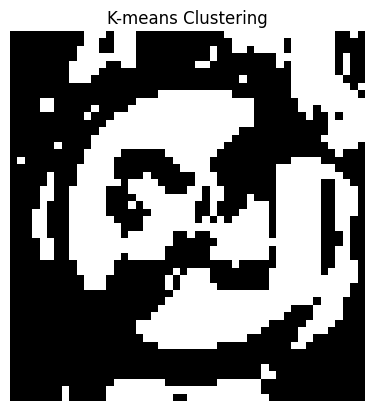

In [ ]:
def extract_roi_kmeans(scorecam_path, k=2):
    scorecam_img = cv2.imread(scorecam_path, cv2.IMREAD_GRAYSCALE)
    if scorecam_img is None:
        raise ValueError(f"Unable to read the image at {scorecam_path}")

    pixel_values = scorecam_img.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)

    _, labels, centers = cv2.kmeans(pixel_values, k, None,
                                    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                    attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS)

    labels = labels.flatten()
    segmented_image = centers[labels].reshape(scorecam_img.shape)

    return np.uint8(segmented_image)

# Example
segmented_image = extract_roi_kmeans(scorecam_path)
plt.imshow(segmented_image, cmap='gray')
plt.title('K-means Clustering')
plt.axis('off')
plt.show()


##Segmentation using HSV from [article](https://towardsdatascience.com/image-segmentation-part-1-6e0ddb5f7f8a)

In [ ]:
from skimage.color import rgb2hsv
#convert to hsv scale
import cv2
from matplotlib import pyplot as plt
import numpy as np

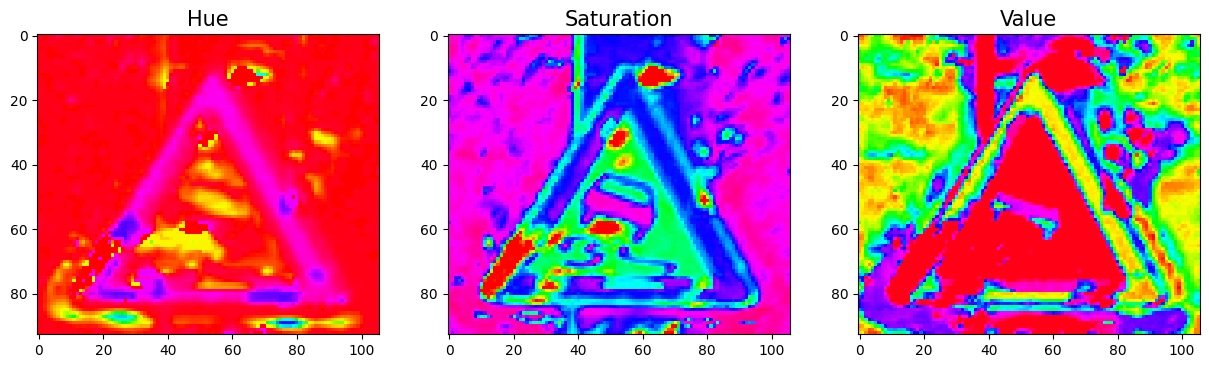

In [ ]:
img = cv2.imread("/content/00023_00002_00025.png")
sample_h= rgb2hsv(img)
#graph per HSV Channel
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(sample_h[:,:,0], cmap='hsv')
ax[0].set_title('Hue',fontsize=15)
ax[1].imshow(sample_h[:,:,1], cmap='hsv')
ax[1].set_title('Saturation',fontsize=15)
ax[2].imshow(sample_h[:,:,2], cmap='hsv')
ax[2].set_title('Value',fontsize=15);
plt.show()

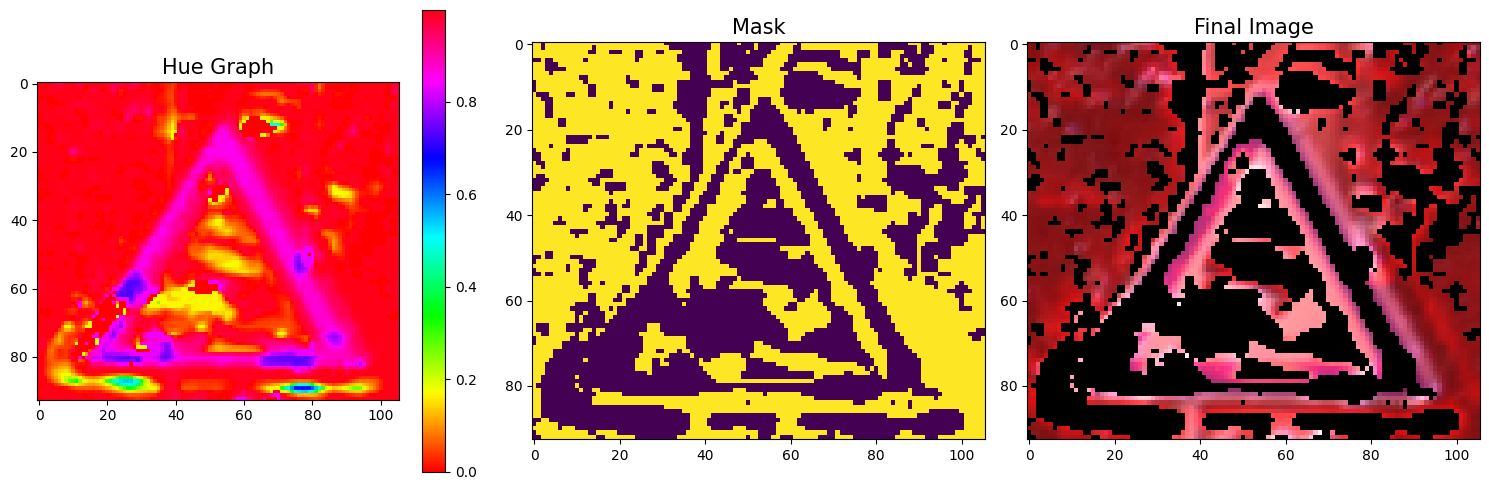

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].imshow(sample_h[:,:,0],cmap='hsv')
fig.colorbar(im,ax=ax[0])
ax[0].set_title('Hue Graph',fontsize=15)
#set the lower and upper mask based on hue colorbar value of the desired fruit
lower_mask = sample_h[:,:,0] > 0.9
upper_mask = sample_h[:,:,0] < 1
mask = upper_mask*lower_mask
# get the desired mask and show in original image
red = img[:,:,0]*mask
green = img[:,:,1]*mask
blue = img[:,:,2]*mask
mask2 = np.dstack((red,green,blue))
ax[1].imshow(mask)
ax[2].imshow(mask2)
ax[1].set_title('Mask',fontsize=15)
ax[2].set_title('Final Image',fontsize=15)
plt.tight_layout()
plt.show()

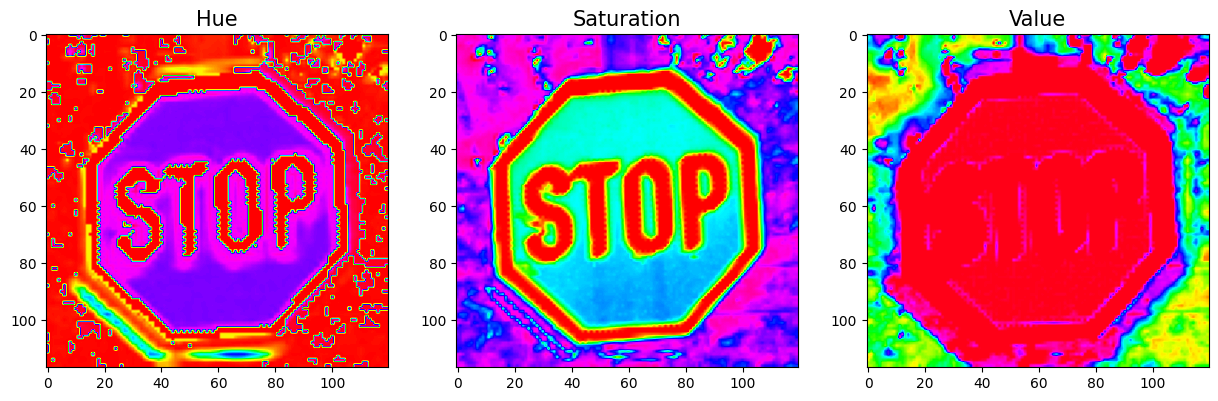

In [ ]:
img = cv2.imread("/content/00014_00003_00025.png")
sample_h= rgb2hsv(img)
#graph per HSV Channel
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(sample_h[:,:,0], cmap='hsv')
ax[0].set_title('Hue',fontsize=15)
ax[1].imshow(sample_h[:,:,1], cmap='hsv')
ax[1].set_title('Saturation',fontsize=15)
ax[2].imshow(sample_h[:,:,2], cmap='hsv')
ax[2].set_title('Value',fontsize=15);
plt.show()

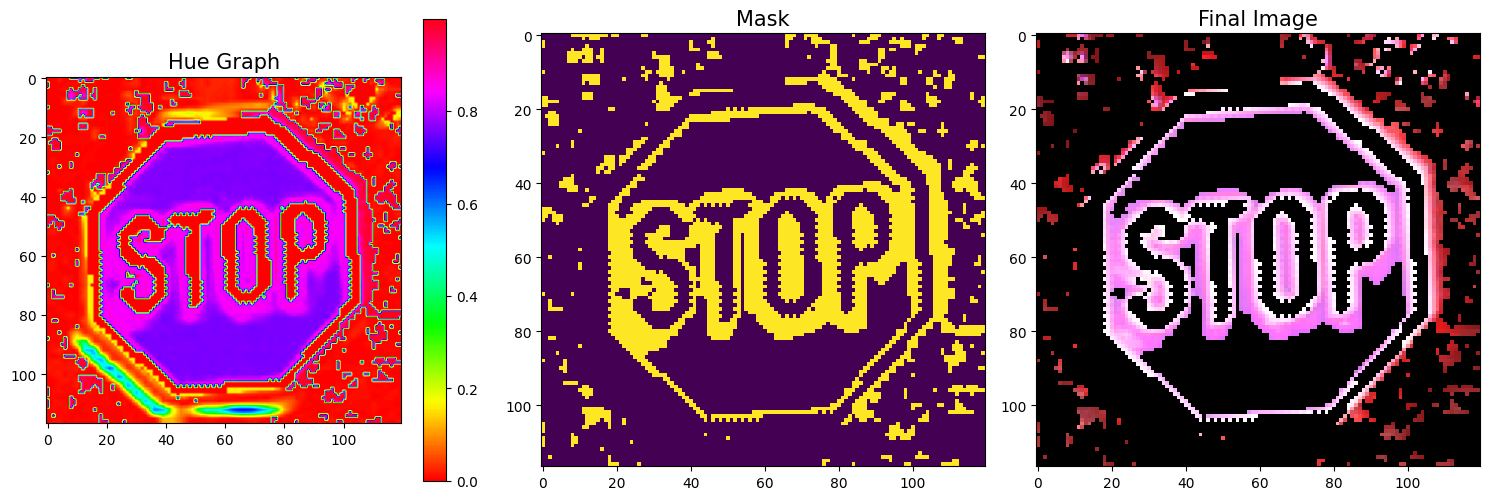

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].imshow(sample_h[:,:,0],cmap='hsv')
fig.colorbar(im,ax=ax[0])
ax[0].set_title('Hue Graph',fontsize=15)
#set the lower and upper mask based on hue colorbar value of the desired fruit
lower_mask = sample_h[:,:,0] > 0.8
upper_mask = sample_h[:,:,0] < 1
mask = upper_mask*lower_mask
# get the desired mask and show in original image
red = img[:,:,0]*mask
green = img[:,:,1]*mask
blue = img[:,:,2]*mask
mask2 = np.dstack((red,green,blue))
ax[1].imshow(mask)
ax[2].imshow(mask2)
ax[1].set_title('Mask',fontsize=15)
ax[2].set_title('Final Image',fontsize=15)
plt.tight_layout()
plt.show()

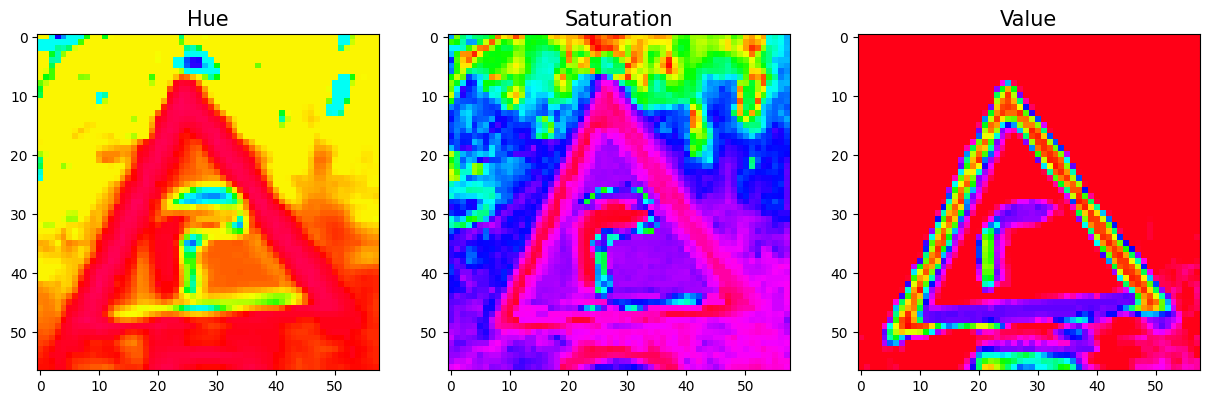

In [ ]:
img = cv2.imread("/content/00020_00002_00021.png")
sample_h= rgb2hsv(img)
#graph per HSV Channel
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(sample_h[:,:,0], cmap='hsv')
ax[0].set_title('Hue',fontsize=15)
ax[1].imshow(sample_h[:,:,1], cmap='hsv')
ax[1].set_title('Saturation',fontsize=15)
ax[2].imshow(sample_h[:,:,2], cmap='hsv')
ax[2].set_title('Value',fontsize=15);
plt.show()

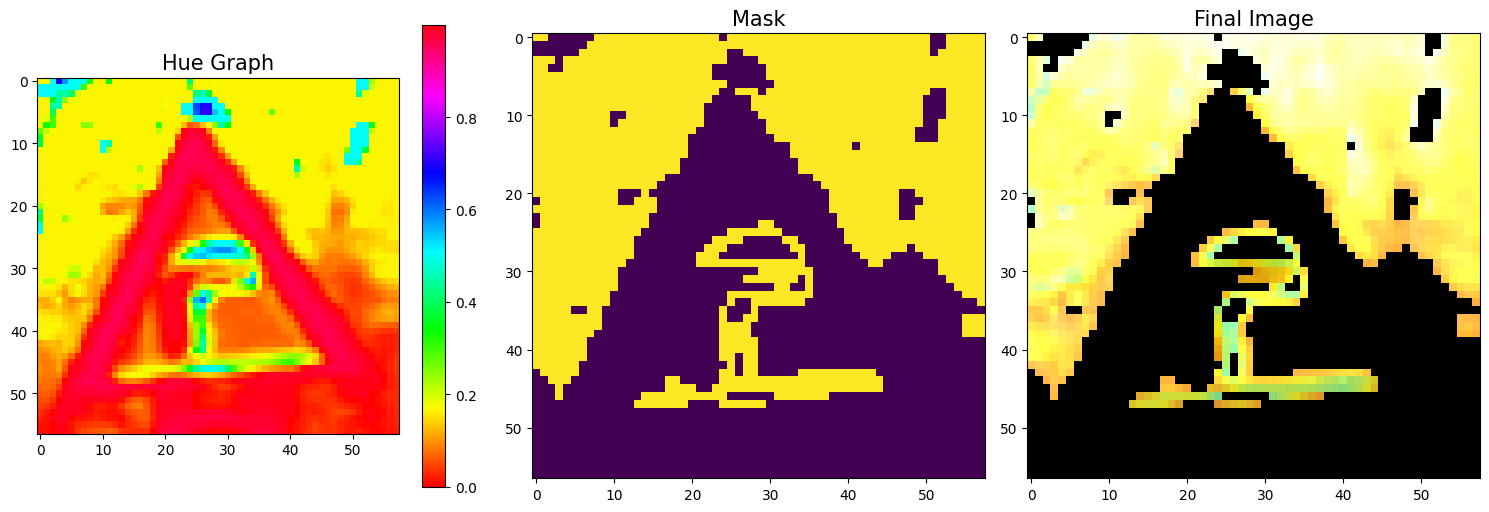

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].imshow(sample_h[:,:,0],cmap='hsv')
fig.colorbar(im,ax=ax[0])
ax[0].set_title('Hue Graph',fontsize=15)
#set the lower and upper mask based on hue colorbar value of the desired fruit
lower_mask = sample_h[:,:,0] > 0.1
upper_mask = sample_h[:,:,0] < 0.4
mask = upper_mask*lower_mask
# get the desired mask and show in original image
red = img[:,:,0]*mask
green = img[:,:,1]*mask
blue = img[:,:,2]*mask
mask2 = np.dstack((red,green,blue))
ax[1].imshow(mask)
ax[2].imshow(mask2)
ax[1].set_title('Mask',fontsize=15)
ax[2].set_title('Final Image',fontsize=15)
plt.tight_layout()
plt.show()

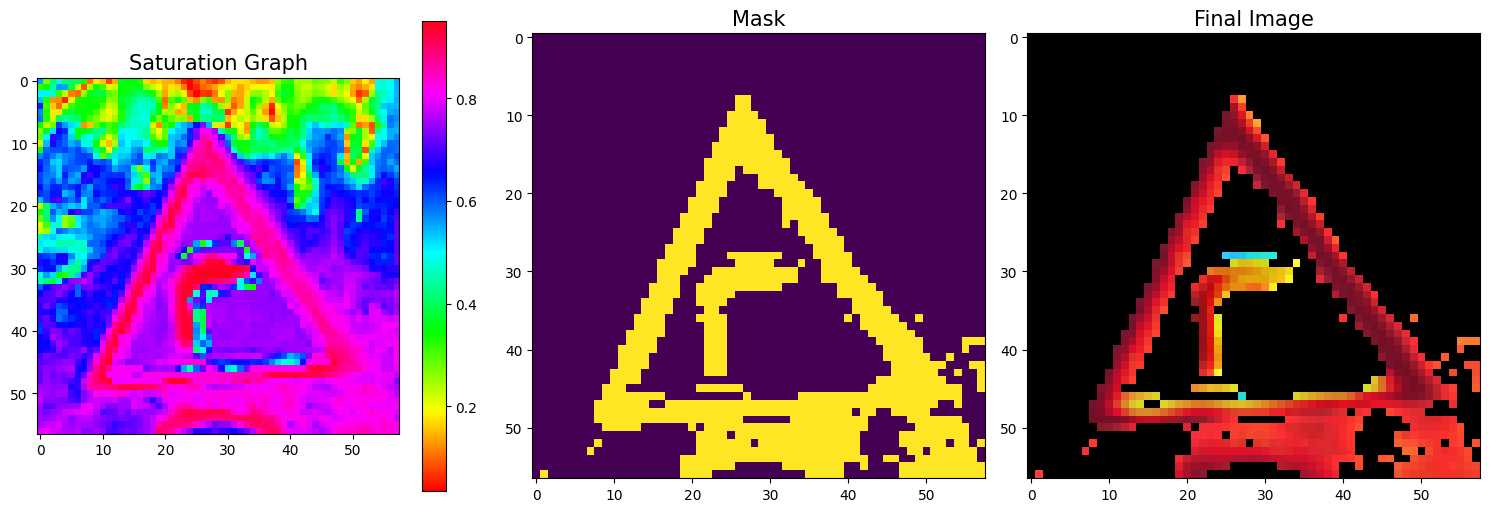

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].imshow(sample_h[:,:,1],cmap='hsv')
fig.colorbar(im,ax=ax[0])
ax[0].set_title('Saturation Graph',fontsize=15)
#set the lower and upper mask based on hue colorbar value of the desired fruit
lower_mask = sample_h[:,:,1] > 0.8
upper_mask = sample_h[:,:,1] < 1
mask = upper_mask*lower_mask
# get the desired mask and show in original image
red = img[:,:,0]*mask
green = img[:,:,1]*mask
blue = img[:,:,2]*mask
mask2 = np.dstack((red,green,blue))
ax[1].imshow(mask)
ax[2].imshow(mask2)
ax[1].set_title('Mask',fontsize=15)
ax[2].set_title('Final Image',fontsize=15)
plt.tight_layout()
plt.show()

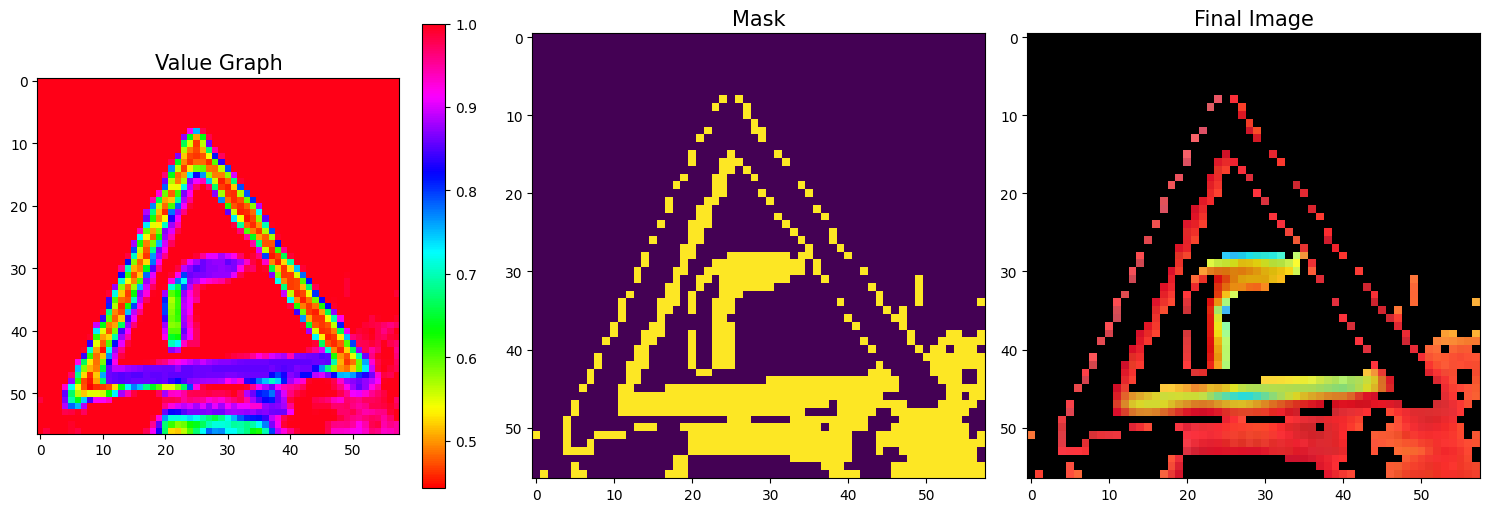

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].imshow(sample_h[:,:,2],cmap='hsv')
fig.colorbar(im,ax=ax[0])
ax[0].set_title('Value Graph',fontsize=15)
#set the lower and upper mask based on hue colorbar value of the desired fruit
lower_mask = sample_h[:,:,2] > 0.8
upper_mask = sample_h[:,:,2] < 1
mask = upper_mask*lower_mask
# get the desired mask and show in original image
red = img[:,:,0]*mask
green = img[:,:,1]*mask
blue = img[:,:,2]*mask
mask2 = np.dstack((red,green,blue))
ax[1].imshow(mask)
ax[2].imshow(mask2)
ax[1].set_title('Mask',fontsize=15)
ax[2].set_title('Final Image',fontsize=15)
plt.tight_layout()
plt.show()